In [39]:
print("init...")
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")
print("init done.")



init...
init done.


In [40]:
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

Данные из предоставленного датасета

            Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-07-23   12873
2020-07-24   13026
2020-07-25   13172
2020-07-26   13249
2020-07-27   13334

[188 rows x 1 columns]


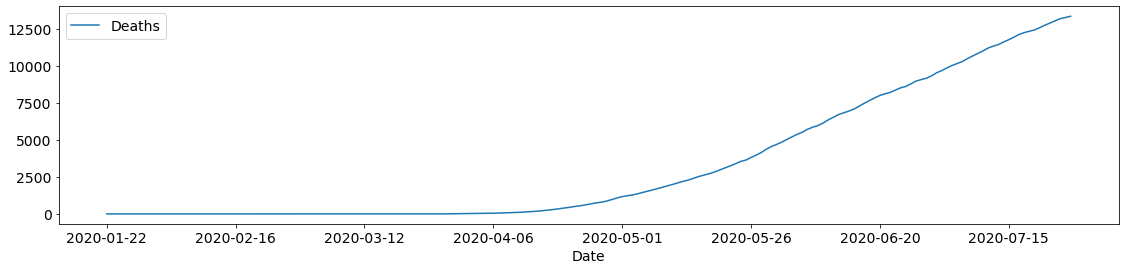

In [41]:
data=pd.read_csv("data/full_grouped.csv")
data=data.loc[data['Country/Region'] == "Russia"]
data.drop("Country/Region",1, inplace=True)
data.drop("WHO Region",1, inplace=True)
y=data.loc[:,["Date","Deaths"]]
y=y.set_index(["Date"])
# y2=y.copy()
# y2=y2[-10:]
# y=y[:-10]
print(y)
# print(y2)
y.plot(figsize=(19,4))
# y2.plot(figsize=(19,4))
plt.show()

Данные из Yandex DataLens

data=pd.read_csv("data/covid.csv", sep=";")
data=data.loc[data['Страна'] == "Россия"]
data.drop("Страна",1, inplace=True)
y=data.loc[:,["Дата","Смертей"]]
y=y.set_index(["Дата"])
print(y)
y.plot(figsize=(19,4))
plt.show()

In [42]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [43]:
aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
# aic_miss = pd.DataFrame(np.zeros((6,6), dtype=float))
# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(y, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan
            
        #        # Estimate the model with missing datapoints
        # mod = sm.tsa.statespace.SARIMAX(y2, order=(p,0,q), enforce_invertibility=False)
        # try:
        #     res = mod.fit(disp=False)
        #     aic_miss.iloc[p,q] = res.aic
        # except:
        #     aic_miss.iloc[p,q] = np.nan


In [44]:
print(aic_full,"\n")
aic_filter=np.nan_to_num(aic_full)
i,j=np.where(aic_filter==np.min(aic_filter[np.nonzero(aic_filter)]))
print("min aic[%s][%s]:"%(j[0],i[0]) ,aic_full[j[0]][i[0]])
print("ARIMA(%s,%s)"%(i[0],j[0]))

             0            1            2            3            4  \
0     0.000000  3636.182357  3274.274370  3116.123679  2892.310404   
1  2282.095147  2086.543624  1977.564791  1939.886334  1879.267024   
2  1770.259573  1742.928466  2092.473791  1776.365326  1937.765273   
3  1766.911329  1876.736600    12.000000  1734.163968  1760.685712   
4          NaN  1817.191645  1776.208161  1755.724410  1827.121400   
5  1795.444195  1810.251374  1776.461929  1782.377309  1868.165414   

             5  
0  2750.476605  
1  1858.425961  
2  1710.804333  
3  1860.074627  
4  1758.089604  
5  1842.445933   

min aic[2][3]: 12.0
ARIMA(3,2)


In [45]:
# print(aic_miss,"\n")
# aic_filter=np.nan_to_num(aic_miss)
# i,j=np.where(aic_filter==np.min(aic_filter[np.nonzero(aic_filter)]))
# print("min aic[%s][%s]:"%(j[0],i[0]) ,aic_miss[j[0]][i[0]])
# print("ARIMA(%s,%s)"%(i[0],j[0]))

In [46]:
mod = sm.tsa.statespace.SARIMAX(y, order=(i[0],0,j[0]))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 Deaths   No. Observations:                  188
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -867.473
Date:                Sun, 02 Jan 2022   AIC                           1746.945
Time:                        02:54:45   BIC                           1766.364
Sample:                    01-22-2020   HQIC                          1754.813
                         - 07-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9965     10.739      0.093      0.926     -20.051      22.044
ar.L2          0.9998     21.440      0.047      0.963     -41.022      43.022
ar.L3         -0.9964     10.702     -0.093      0.9

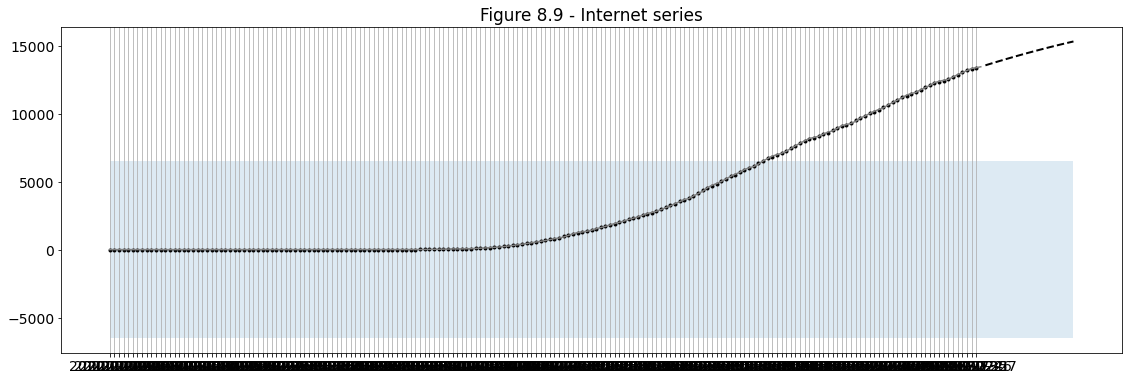

In [47]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 20
predict = res.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)
# Graph
fig, ax = plt.subplots(figsize=(19,6))
ax.xaxis.grid()
ax.plot(y, 'k.')
# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
try:
    ax.fill_between(idx, predict_ci.loc[:,["lower Deaths"]].values[0], predict_ci.loc[:,["upper Deaths"]].values[0], alpha=0.15)
except KeyError:
    ax.fill_between(idx, predict_ci.loc[:,["lower Смертей"]].values[0], predict_ci.loc[:,["upper Смертей"]].values[0], alpha=0.15)
ax.set(title='Figure 8.9 - Internet series')
plt.show()